# League of Legends Match Outcome Prediction: Decision Tree Evolution
This notebook performs a deep dive into match statistics to predict winners using **Decision Trees**. 
We will perform Exploratory Data Analysis (EDA), clean the data, and iteratively improve our model to find the most efficient "Road to Victory".

## 1. Import Libraries
We import specialized libraries for data manipulation, statistical visualization, and machine learning.

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Styling
plt.style.use('fivethirtyeight')
%matplotlib inline

# Result storage
all_results = {}

## 2. Load and Inspect Data
We load the dataset and check for its structure and initial statistics.

In [198]:
df = pd.read_csv("./data/lol_data_engineered.csv")
df = df.drop(columns=['Unnamed: 21', 'matchId'], errors='ignore').dropna()
print(f"Dataset loaded with {df.shape[0]} samples.")
df.describe()

Dataset loaded with 299993 samples.


,match_length,win,kills,deaths,assists,gold at 15,cs at 15,team_first_tower,team_first_dragon,team_first_baron,...,team_total_kills,team_total_gold,team_total_damage,team_total_cs,KP,Gold_Share,Damage_Share,CS_Share,Gold_at_15_PM,CS_at_15_PM
count,299993.000000,299993.000000,299993.000000,299993.000000,299993.000000,299993.000000,299993.000000,299993.000000,299993.000000,299993.000000,...,299993.000000,299993.000000,299993.000000,299993.000000,299993.000000,299993.000000,299993.000000,299993.000000,299993.000000,299993.000000
mean,1727.246199,0.500008,5.971129,5.990923,8.404036,5460.515599,88.920578,0.499472,0.499758,0.314754,...,29.855240,58418.180924,106198.073872,819.310967,0.475748,0.200002,0.200004,0.200003,364.034373,5.928039
std,363.562226,0.500001,4.598909,3.152730,6.067581,1058.890175,38.234005,0.500001,0.500001,0.464419,...,11.861486,14419.877686,41906.005592,168.689078,0.160124,0.037884,0.077201,0.087110,70.592678,2.548934
min,910.000000,0.000000,0.000000,0.000000,0.000000,2208.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,17887.000000,12746.000000,284.000000,0.000000,0.070556,0.000000,0.000000,147.200000,0.000000
25%,1518.000000,0.000000,2.000000,4.000000,4.000000,4713.000000,80.000000,0.000000,0.000000,0.000000,...,21.000000,49292.000000,77900.000000,718.000000,0.368421,0.174575,0.146164,0.187160,314.200000,5.333333
50%,1716.000000,1.000000,5.000000,6.000000,7.000000,5414.000000,101.000000,0.000000,0.000000,0.000000,...,30.000000,58862.000000,103040.000000,821.000000,0.478261,0.202078,0.198942,0.229167,360.933333,6.733333
75%,1937.000000,1.000000,9.000000,8.000000,11.000000,6144.000000,115.000000,1.000000,1.000000,1.000000,...,38.000000,67654.000000,130218.000000,922.000000,0.586207,0.225804,0.250455,0.257075,409.600000,7.666667
max,3630.000000,1.000000,38.000000,24.000000,51.000000,11802.000000,180.000000,1.000000,1.000000,1.000000,...,82.000000,133909.000000,461829.000000,1759.000000,1.000000,0.385188,0.611324,0.437500,786.800000,12.000000


## 3. Exploratory Data Analysis (EDA)
Before modeling, we visualize the relationships between our features and the target variable (`win`).

### 3.1 Target Variable Balance
We check if the dataset is balanced between Wins and Losses.

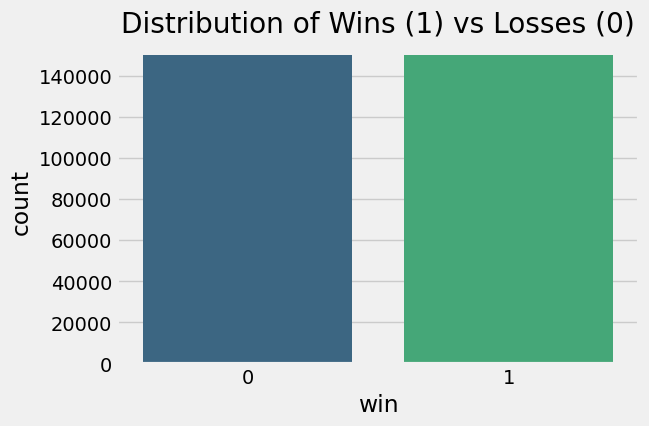

In [199]:
plt.figure(figsize=(6, 4))
sns.countplot(x='win', data=df, hue='win', palette='viridis', legend=False)
plt.title('Distribution of Wins (1) vs Losses (0)')
plt.show()

### 3.2 Correlation Heatmap
We look for features that have the strongest linear relationship with winning.

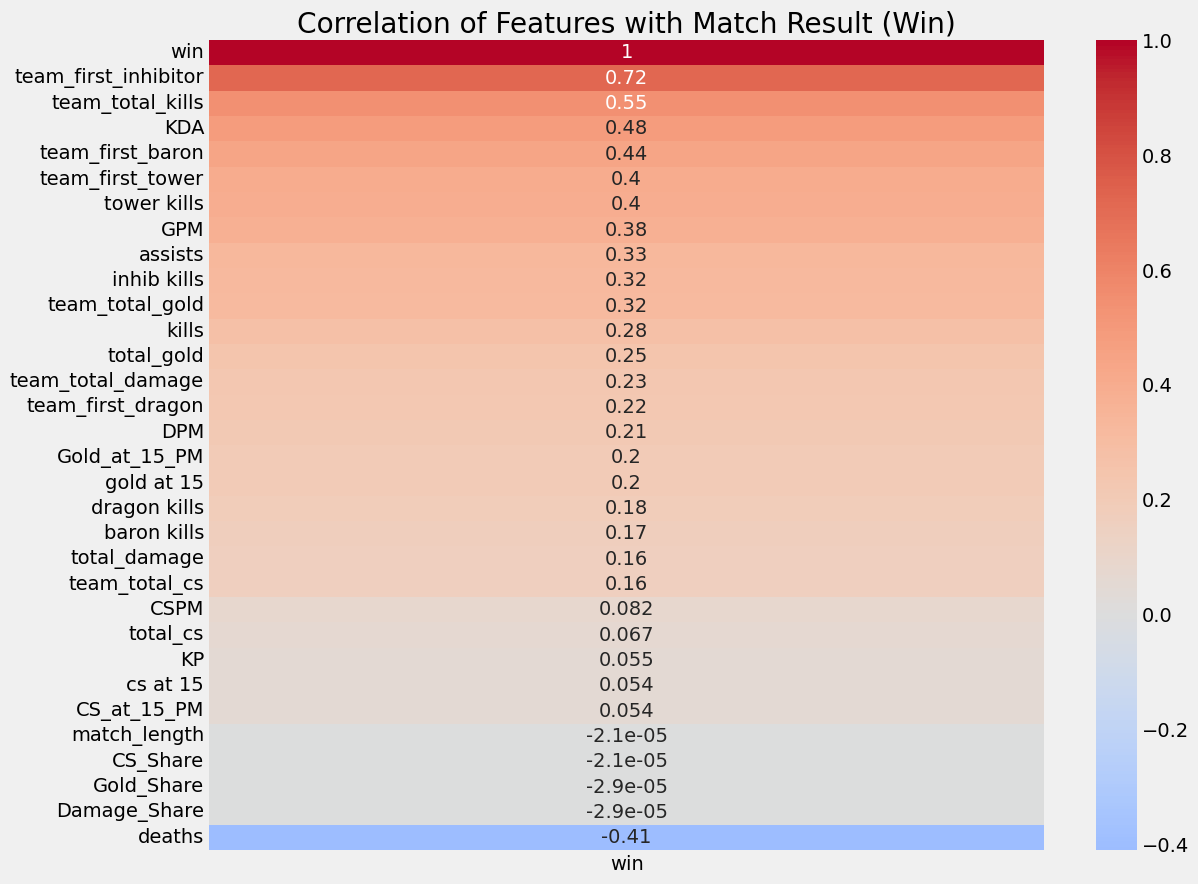

In [200]:
plt.figure(figsize=(12, 10))
# Selecting numerical columns for correlation
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix[['win']].sort_values(by='win', ascending=False), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Features with Match Result (Win)')
plt.show()

### 3.3 Gold at 15: Winners vs Losers
One of our key features is the gold lead at 15 minutes. Let's see how it differs between teams that eventually win or lose.

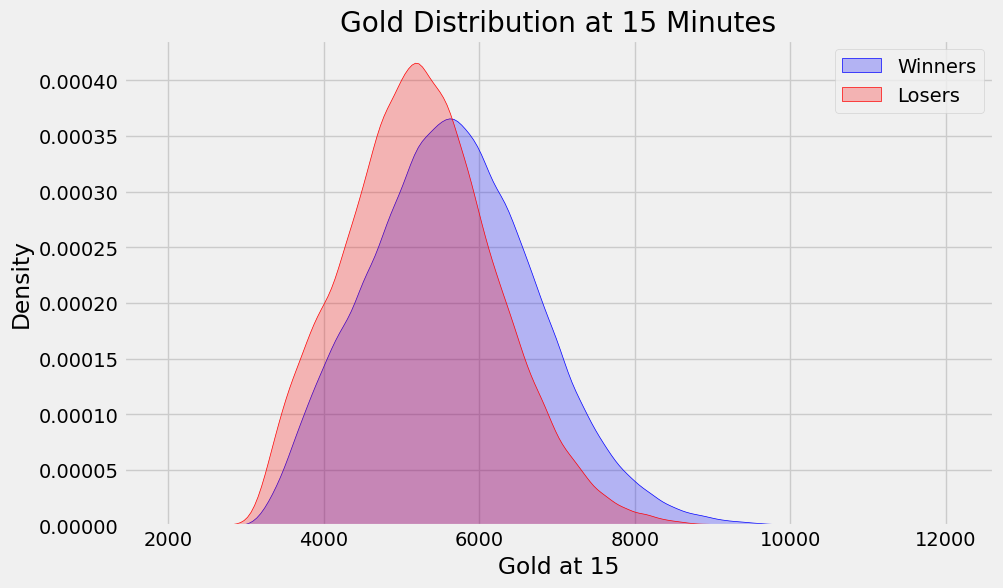

In [201]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['win'] == 1]['gold at 15'], label='Winners', fill=True, color='blue')
sns.kdeplot(df[df['win'] == 0]['gold at 15'], label='Losers', fill=True, color='red')
plt.title('Gold Distribution at 15 Minutes')
plt.xlabel('Gold at 15')
plt.legend()
plt.show()

### 3.4 The Power of the First Baron
We visualize how often taking the first Baron leads to a victory.

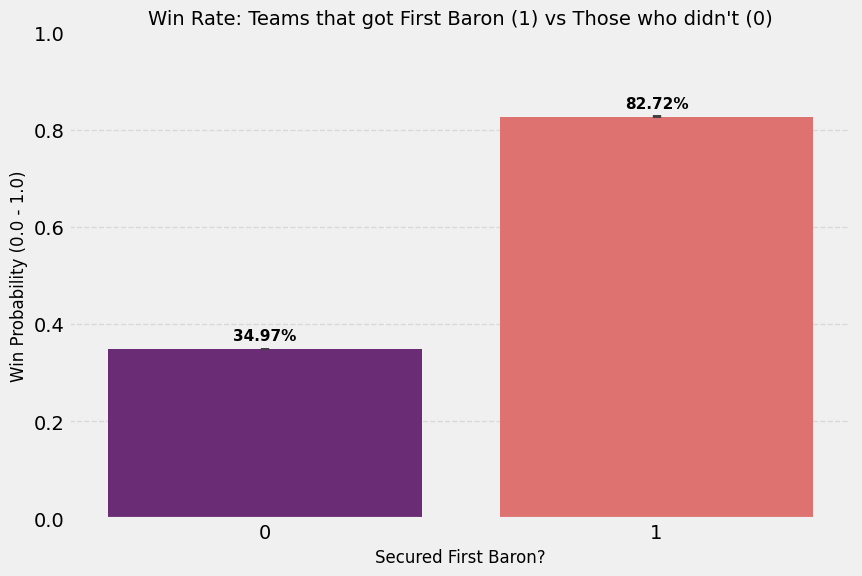

In [202]:
plt.figure(figsize=(9, 6))
ax = sns.barplot(x='team_first_baron', y='win', data=df, hue='team_first_baron', palette='magma', legend=False)
plt.title('Win Rate: Teams that got First Baron (1) vs Those who didn\'t (0)')

plt.title('Win Rate: Teams that got First Baron (1) vs Those who didn\'t (0)', fontsize=14)
plt.ylabel('Win Probability (0.0 - 1.0)', fontsize=12)
plt.xlabel('Secured First Baron?', fontsize=12)
plt.ylim(0, 1) # Probability is always between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.6)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), 
                textcoords='offset points', fontsize=11, fontweight='bold')

plt.show()

### 3.5. Player Performance Profiles (Radar Chart)
We compare the average performance profile of winning teams versus losing teams across multiple key metrics to visualize the "gap" required for victory.

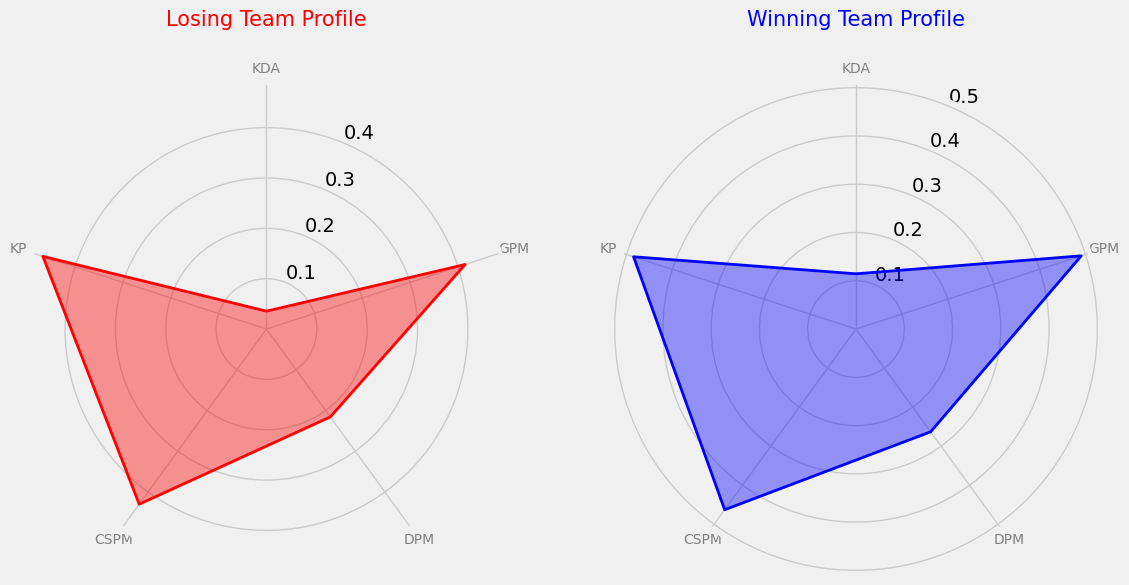

In [203]:
from math import pi

# 1. Prepare data: Normalize metrics between 0 and 1 for the radar chart
radar_cols = ['KDA', 'GPM', 'DPM', 'CSPM', 'KP']
df_radar = df.groupby('win')[radar_cols].mean().reset_index()

# Normalize function
df_norm = df_radar.copy()
for col in radar_cols:
    df_norm[col] = df_norm[col] / df[col].max()

def make_radar(row, title, color):
    categories = radar_cols
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    ax = plt.subplot(1, 2, row+1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    values = df_norm.loc[row].drop('win').values.flatten().tolist()
    values += values[:1]
    
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    plt.title(title, size=15, color=color, y=1.1)

plt.figure(figsize=(12, 6))
make_radar(0, "Losing Team Profile", "red")
make_radar(1, "Winning Team Profile", "blue")
plt.tight_layout()
plt.show()

### 3.6. Performance Density (Violin Plots)
We examine the density distribution of Gold Per Minute (GPM) and Damage Per Minute (DPM) to see how overlapping these metrics are between winners and losers.

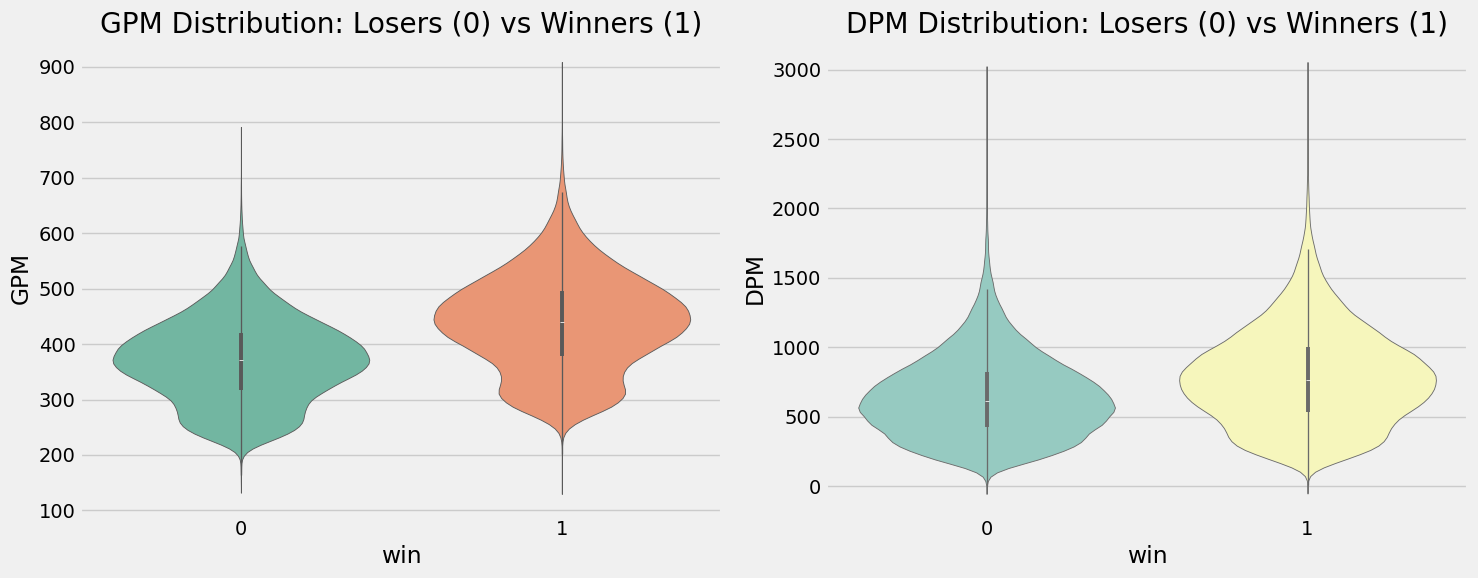

In [204]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for GPM
sns.violinplot(x='win', y='GPM', data=df, ax=axes[0], hue='win', palette='Set2', legend=False)
axes[0].set_title('GPM Distribution: Losers (0) vs Winners (1)')

# Plot for DPM
sns.violinplot(x='win', y='DPM', data=df, ax=axes[1], hue='win', palette='Set3', legend=False)
axes[1].set_title('DPM Distribution: Losers (0) vs Winners (1)')

plt.tight_layout()
plt.show()

## 4. Preprocessing & Encoding
We transform the categorical data into numerical format using One-Hot Encoding.

In [205]:
df_encoded = pd.get_dummies(df, columns=['region', 'teamposition'])

## 5. Modeling Phase: Decision Tree Iterations
To maintain consistency, we define a core function `run_model` that handles the training, prediction, and metric calculation for our different experiments.

In [206]:
def run_model(X, y, name, depth=5):
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initializing and training the Decision Tree
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Making predictions
    preds = model.predict(X_test)
    
    # Collecting metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1-Score': f1_score(y_test, preds)
    }
    
    # Storing results for final comparison
    all_results[name] = metrics
    print(f"Metrics for {name} calculated successfully.")
    return model

### 5.1. Step 1: Base Model Training
We start with a "Base Model" using all available features in the encoded dataset. This serves as our benchmark performance before any data refinement.

In [207]:
# Step 1: Base Model
base_model = run_model(df_encoded.drop(columns=['win']), df_encoded['win'], "1. Base Model")

# Displaying base metrics
pd.DataFrame([all_results["1. Base Model"]])

Metrics for 1. Base Model calculated successfully.


,Accuracy,Precision,Recall,F1-Score
0,0.914565,0.911387,0.918318,0.914839


### 5.2. Step 2: Handling Outliers
Statistical outliers can bias the decision nodes of a tree. We apply the Interquartile Range (IQR) method on key performance indicators (Gold, Kills, Deaths, GPM) to create a cleaner training set.

In [208]:
# Identifying columns to clean
num_cols = ['total_gold', 'kills', 'deaths', 'GPM']
df_cleaned = df.copy()

for col in num_cols:
    Q1, Q3 = df_cleaned[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    # Filtering the data
    df_cleaned = df_cleaned[(df_cleaned[col] >= Q1 - 1.5*IQR) & (df_cleaned[col] <= Q3 + 1.5*IQR)]

print(f"Data reduction after outlier removal: {len(df) - len(df_cleaned)} rows removed.")


Data reduction after outlier removal: 10776 rows removed.


We retrain the model on this refined dataset to see if removing extreme noise improves the tree's stability.

In [209]:
# Preparing features for the cleaned dataset
X_c = pd.get_dummies(df_cleaned.drop(columns=['win', 'Unnamed: 21', 'matchId'], errors='ignore'), 
                     columns=['region', 'teamposition'])
y_c = df_cleaned['win']

# Running Model 2
outlier_model = run_model(X_c, y_c, "2. No Outliers")

pd.DataFrame([all_results["2. No Outliers"]])

Metrics for 2. No Outliers calculated successfully.


,Accuracy,Precision,Recall,F1-Score
0,0.918159,0.922366,0.91045,0.916369


### 5.3. Step 3: Strategic Feature Selection (Minute 15 focus)
To prevent "Data Leakage" (predicting based on end-game stats) and to make the model useful for live predictions, we restrict the features to **Early Game** statistics and the **First Baron** win condition.

In [ ]:
# Focusing on what matters at Minute 15 + Key Objective
selected_features = [
    'gold at 15', 'cs at 15', 
    'team_first_tower', 'team_first_dragon', 'team_first_baron'
]

# Running the final strategic model with a lower depth for better interpretability
final_model = run_model(df_cleaned[selected_feats], df_cleaned['win'], "3. Strategic (Min 15)", depth=3)

# View summary of all iterations so far
pd.DataFrame(all_results).T

Metrics for 3. Strategic (Min 15) calculated successfully.


,Accuracy,Precision,Recall,F1-Score
1. Base Model,0.914565,0.911387,0.918318,0.914839
2. No Outliers,0.918159,0.922366,0.910450,0.916369
3. Strategic (Min 15),0.776295,0.778171,0.763366,0.770697


## 6. Comparison with XGBoost
We compare our interpretable Decision Tree with the high-performance XGBoost model results.

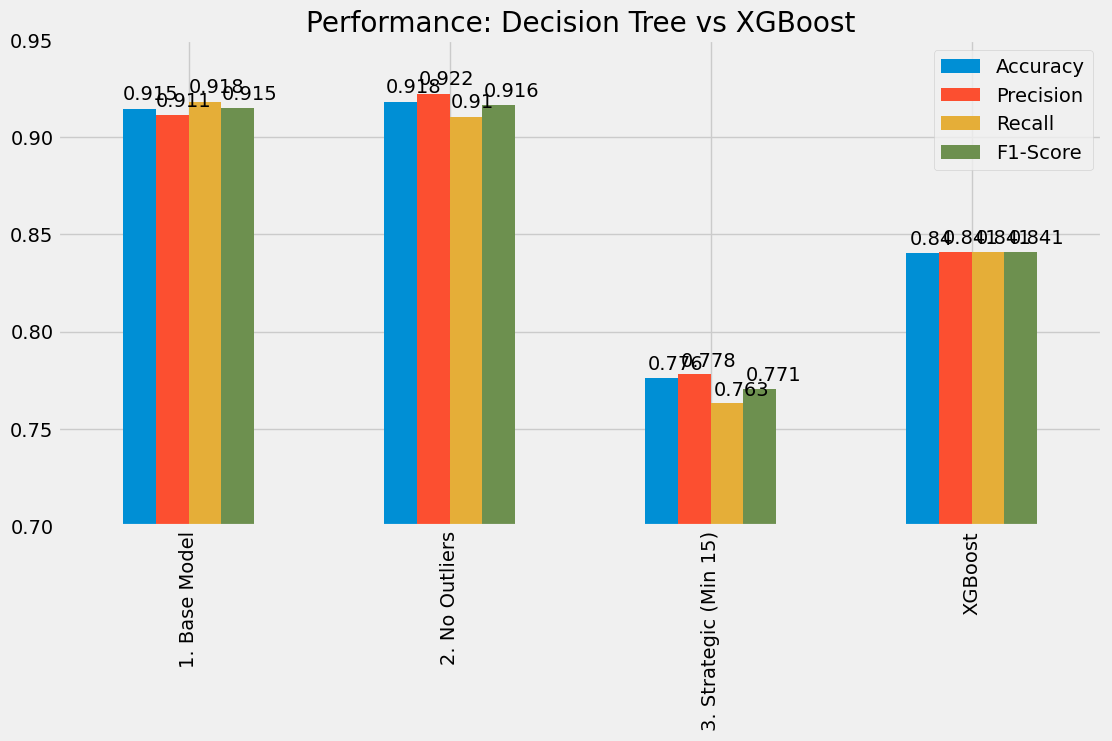

In [211]:
# Adding XGBoost data
all_results["XGBoost"] = {'Accuracy': 0.840404, 'Precision': 0.841084, 'Recall': 0.841118, 'F1-Score': 0.841101}

res_df = pd.DataFrame(all_results).T
ax = res_df.plot(kind='bar', figsize=(12, 6), ylim=(0.7, 0.95))
plt.title("Performance: Decision Tree vs XGBoost")
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 3)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

## 7. Visualizing the Decision Tree
The following tree shows the hierarchy of importance for winning a match.

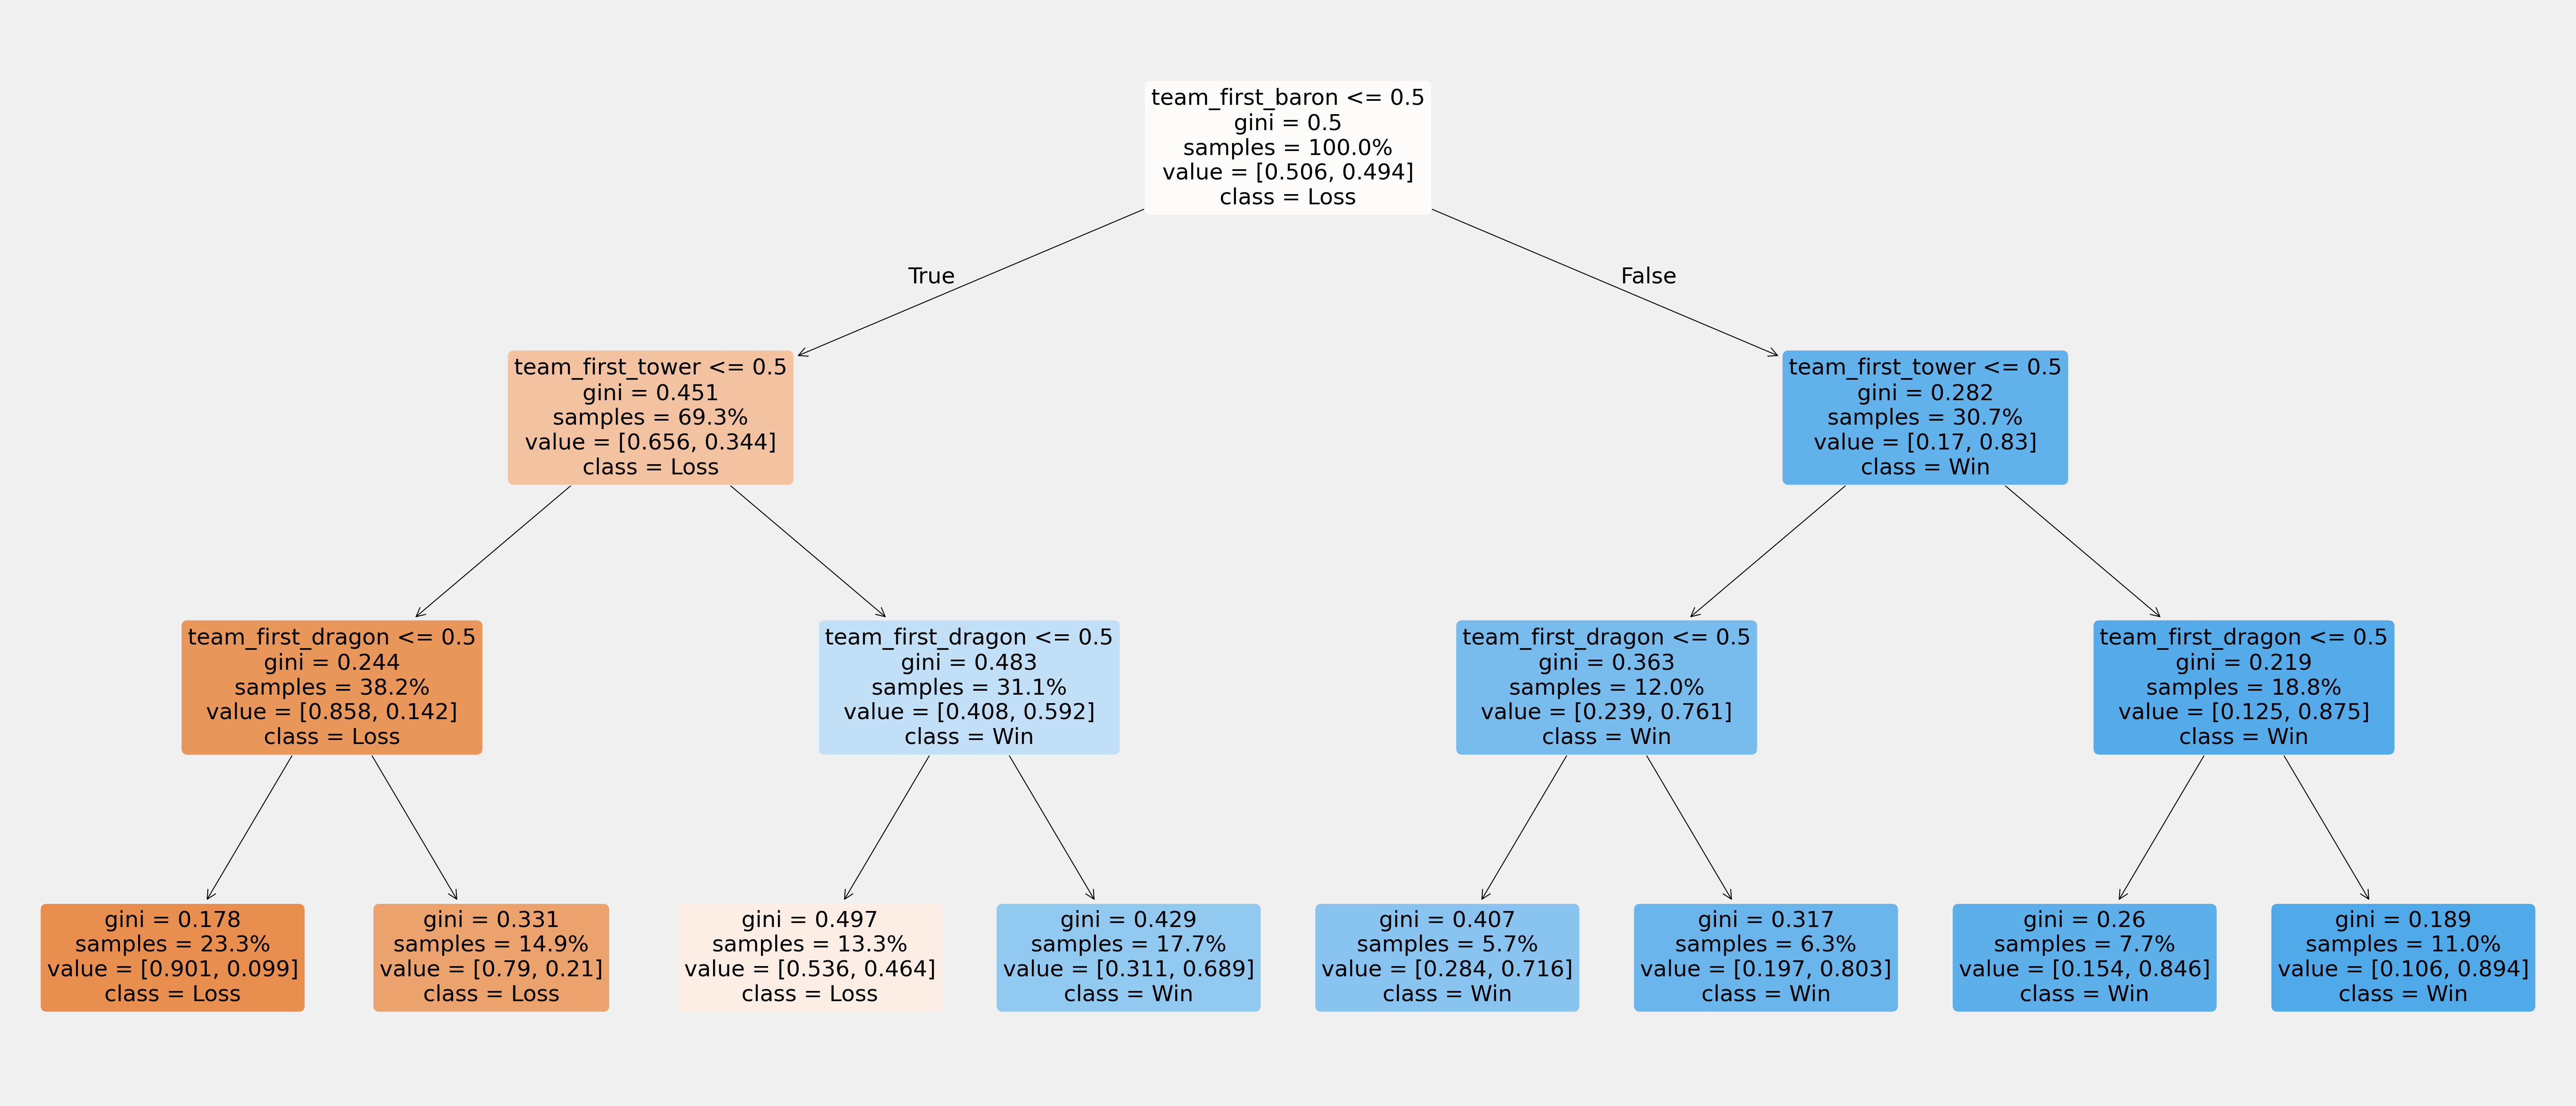

In [212]:
plt.figure(figsize=(22, 10), dpi=300)
plot_tree(final_model, feature_names=selected_feats, class_names=['Loss', 'Win'], filled=True, rounded=True, fontsize=12, proportion=True)
plt.show()

### 7.1. Detailed Error Analysis (Confusion Matrix)
To understand not just *how often* the model is right, but *where* it makes mistakes, we use a **Confusion Matrix**. 
- **True Positives (Bottom-Right):** Matches predicted as Wins that were actually Wins.
- **True Negatives (Top-Left):** Matches predicted as Losses that were actually Losses.
- **False Positives (Top-Right):** The model predicted a Win, but the team lost ("Overconfidence").
- **False Negatives (Bottom-Left):** The model predicted a Loss, but the team won ("Underestimation").

In [213]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

selected_feats = ['gold at 15', 'cs at 15', 'team_first_tower', 'team_first_dragon', 'team_first_baron']

X_final = df_cleaned[selected_feats]
y_final = df_cleaned['win']

# Re-running split to ensure variables are in memory
Xfs_train, Xfs_test, yfs_train, yfs_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# generate predictions
fs_preds = final_model.predict(Xfs_test) 

# Plotting
plt.figure(figsize=(7, 5))
cm = confusion_matrix(yfs_test, fs_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Loss', 'Predicted Win'], 
            yticklabels=['Actual Loss', 'Actual Win'])

plt.title('Confusion Matrix: Strategic Model Predictions')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Gold_at_15_PM


### 7.2. Feature Importance Ranking
This chart identifies which of our selected early-game features (Minute 15 stats vs Objectives) had the most significant impact on the model's decision-making process.

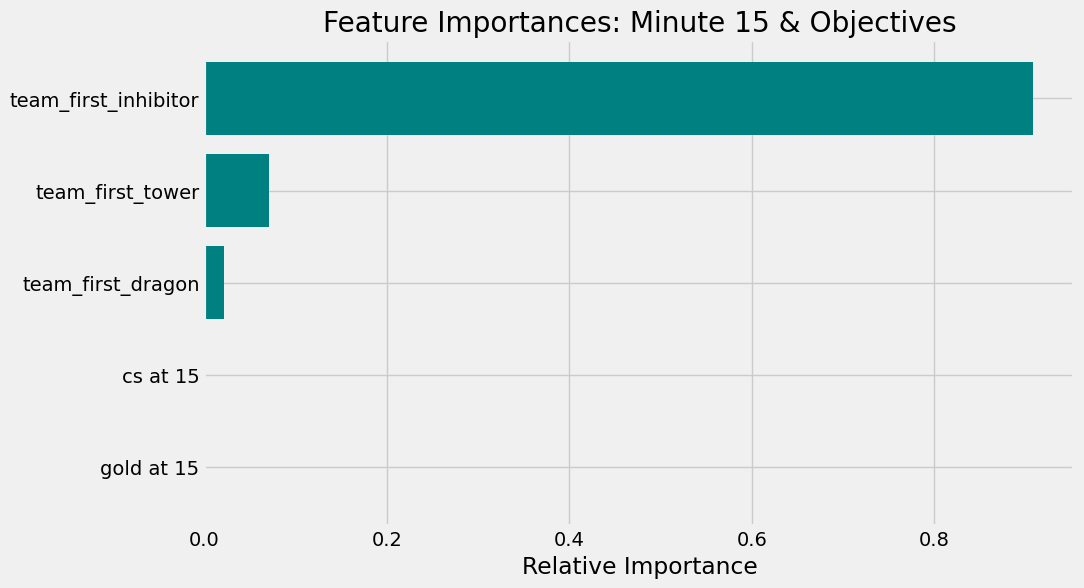

In [ ]:
# Extracting feature importances
importances = final_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances: Minute 15 & Objectives')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [selected_feats[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()